# Characterize Mercer, Novel, All BPs

For each group plot:
- Phastcons
- PhyloP
- Distance from 3'ss
- PWM

both seperately and all on one plot.

In [88]:
import numpy as np
from scipy.stats import cumfreq
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
# file is result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, gene, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        gene = gene.split(':')[-1]
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand, gene)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [4]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)
print known.keys()[0]

37110
169182
('chr16', 70399987, '+', 'RP11-529K1.3')


In [7]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns):
    X, y, chroms, coords, strands, genes = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand, gene = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        X += [onehot(seq).reshape(1, L, 4)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
        genes += [gene]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords),
            np.array(strands), np.array(genes))

(X_known, y_known,
 k_chroms, k_coords,
 k_strands, k_genes) = encode(known)
(X_novel, y_novel, 
 n_chroms, n_coords,
 n_strands, n_genes) = encode(missing)

print np.sum(y_novel), np.sum(y_known)
print X_novel.shape, X_known.shape

0.0 56808.0
(169182, 70, 4) (37110, 70, 4)


In [8]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [9]:
y_novel = model.predict(X_novel).reshape(-1, L)
p_known = model.predict(X_known).reshape(-1, L)

X_all = np.vstack([X_novel, X_known])
y_all = np.vstack([y_novel, p_known])

In [10]:
a_chroms  = np.hstack([n_chroms,  k_chroms])
a_coords  = np.hstack([n_coords,  k_coords])
a_strands = np.hstack([n_strands, k_strands])
a_genes = np.hstack([n_genes, k_genes])

# ISM

In [84]:
from sklearn.utils import shuffle
import pandas

def read_variants(fn):
    return shuffle(pandas.read_csv(fn, delimiter = '\t'))

pathogenic = read_variants('../../variants/hg19.pathogenicv2.features.tsv')
benign = read_variants('../../hg19.benign.exons.tsv')

In [85]:
def get_features(p):
    X_ref, X_alt, indexes = [], [], []
    for pos, shift, chrom, strand, ref, alt in zip(p['POS'],
                                                   p["3'Dist"],
                                                   p['CHROM'],
                                                   p['strand'],
                                                   p['REF'],
                                                   p['ALT']):
        chrom = 'chr'+str(chrom)
        three = pos + (-shift if strand == '+' else shift-1)
        if strand == '+':
            begin, stop = three - L, three + len(ref) - 1
        else:
            begin, stop = three - len(ref)+1, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        X_ref += [onehot(seq[-70:]).reshape(1, 70, 4)]
        indexes += [L+shift-1]

        altseq = (seq[:indexes[-1]]
                  + (alt if strand == '+' else genome.revcomp(alt))
                  + seq[indexes[-1]+len(ref):])
        X_alt += [onehot(altseq[-70:]).reshape(1, 70, 4)]

    return np.vstack(X_ref), np.vstack(X_alt), np.array(indexes)

def get_stats(ref, alt, indexs):
    old = []
    new = []
    for r, a in zip(ref, alt):
        bp = np.argmax(r)
        old += [a[bp] - r[bp]]
        bp = np.argmax(a)
        new += [a[bp] - r[bp]]
    old = np.array(old)
    new = np.array(new)
    max_delta = np.max(alt, axis = 1) - np.max(ref, axis = 1)
    shift = indexs - np.argmax(ref, axis =1)
    return shift, old, new, max_delta

In [86]:
p = pathogenic[(pathogenic["3'Dist"] > -45) & (pathogenic["3'Dist"] <= -18)]

path_X_ref, path_X_alt, path_indexes = get_features(p)

path_shift, path_delta, path_gain, path_max_delta = get_stats(model.predict(path_X_ref).reshape(-1, L),
                                                              model.predict(path_X_alt).reshape(-1, L),
                                                              path_indexes)

b = benign[(benign["3'Dist"] > -45) & (benign["3'Dist"] <= -18)][:10000]

benign_X_ref, benign_X_alt, benign_indexes = get_features(b)

benign_shift, benign_delta, benign_gain, benign_max_delta = get_stats(model.predict(benign_X_ref).reshape(-1, L),
                                                                      model.predict(benign_X_alt).reshape(-1, L),
                                                                      benign_indexes)

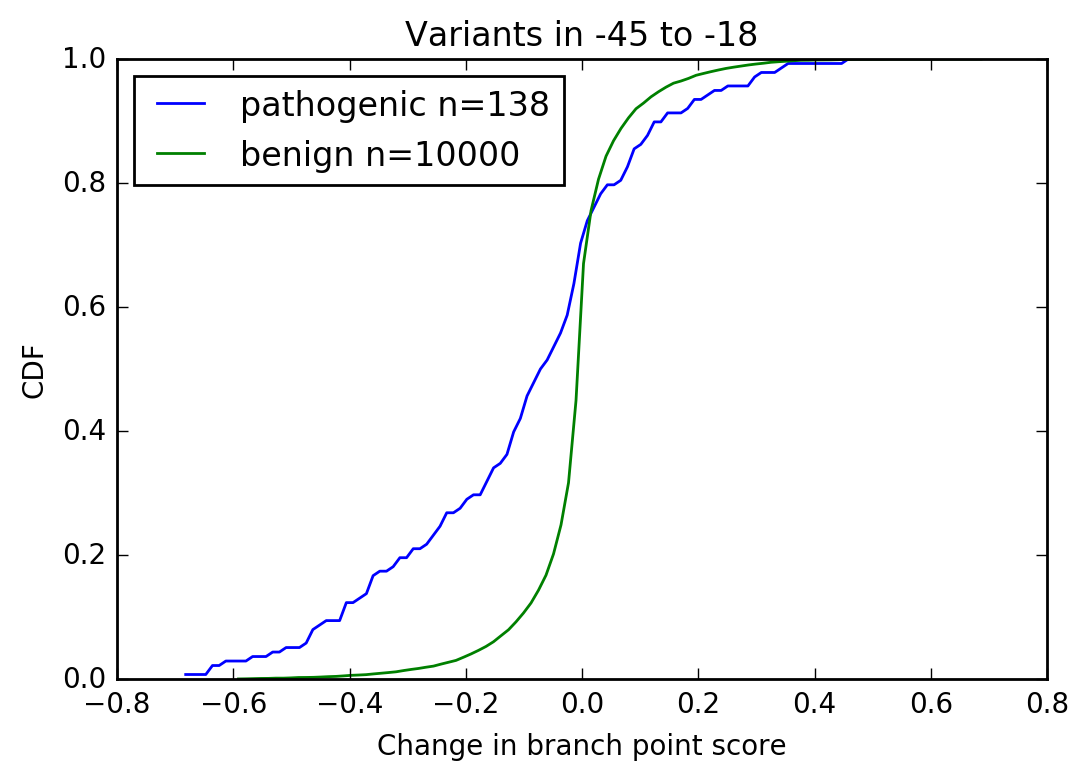

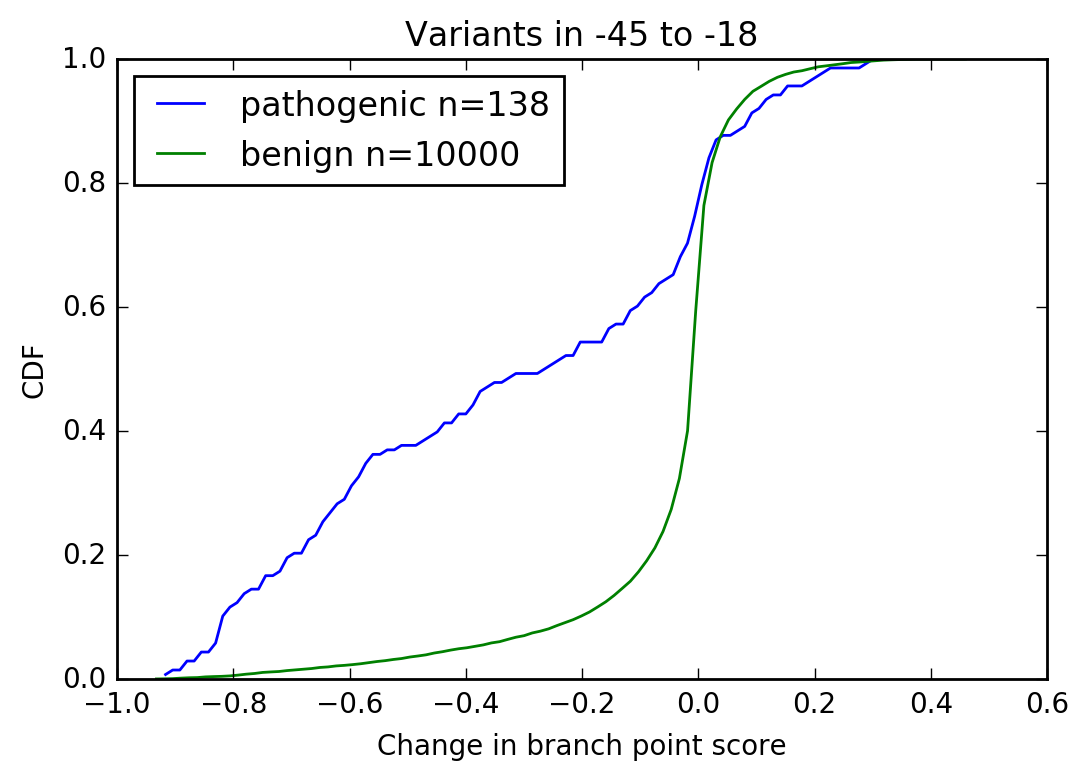

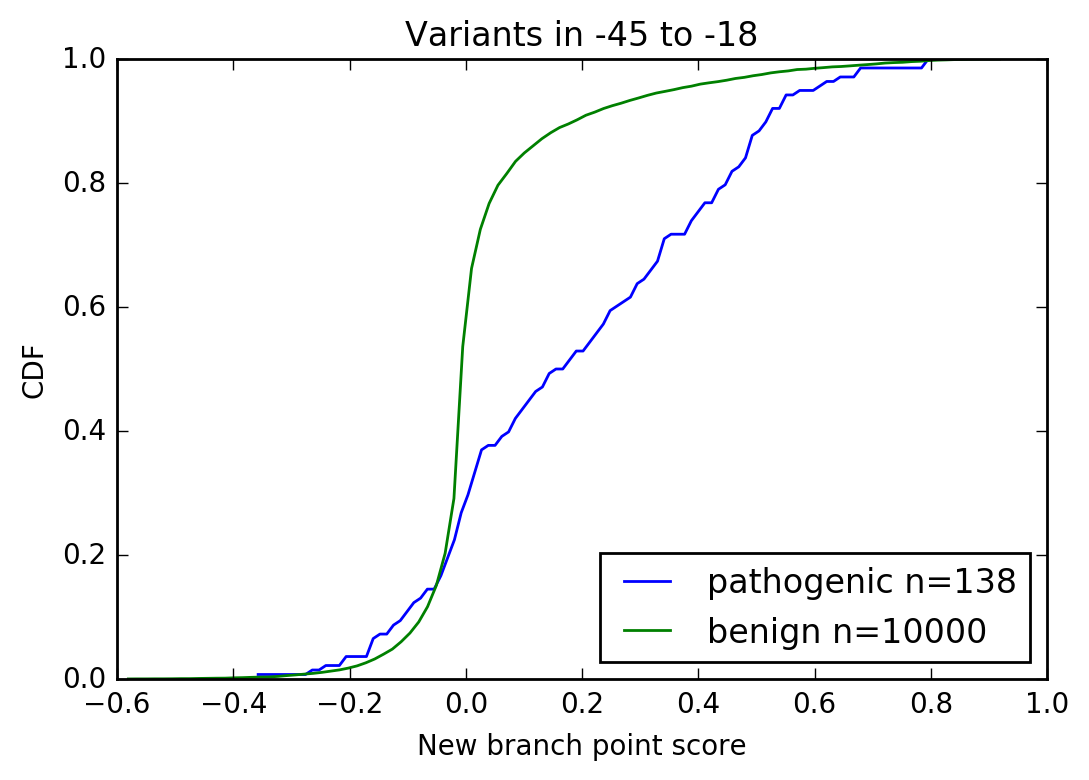

In [89]:
def cdf(a, label, bins = 100):
    c = cumfreq(a, bins)
    lower = c.lowerlimit
    upper = lower + bins * c.binsize
    plt.plot(np.linspace(lower, upper, bins),
             c.cumcount / a.shape[0],
             label = label)
    
def compare_cdfs(path, benign, title, xlabel):
    cdf(path, "pathogenic n={}".format(path.shape[0]))
    cdf(benign, "benign n={}".format(benign.shape[0]))
    plt.legend()
    plt.ylabel('CDF')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend(loc = 'best')
    plt.show()
    
compare_cdfs(path_max_delta, benign_max_delta,
             'Variants in -45 to -18', 'Change in branch point score')
compare_cdfs(path_delta, benign_delta,
             'Variants in -45 to -18', 'Change in branch point score')
compare_cdfs(path_gain, benign_gain,
             'Variants in -45 to -18', 'New branch point score')

# ISM Example

     CHROM REF ALT  3'Dist
9343    21   A   G     -21
(1, 70, 4)
(1, 46, 4)
GGGGCTGGGTGGGACTGGCCCCTGCCCCTGCTCCTCCGGGGGTGTCTCACCATCTCCTCCTGTGTTCCAG
GGGGCTGGGTGGGACTGGCCCCTGCCCCTGCTCCTCCGGGGGTGTCTCGCCATCTCCTCCTGTGTTCCAG


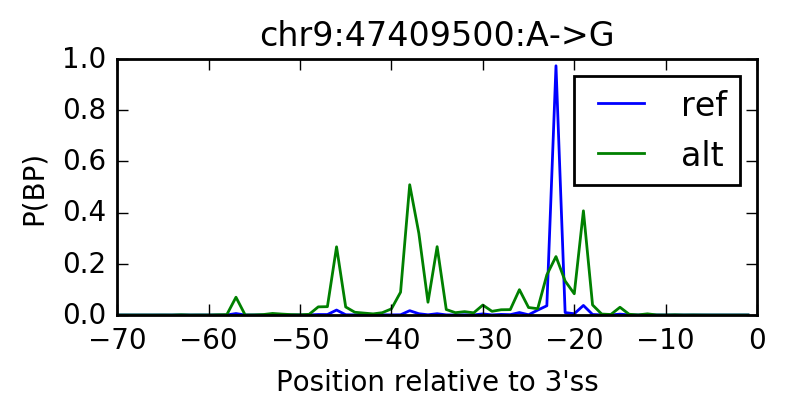

In [92]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

print pathogenic[pathogenic['POS'] == 47409500][['CHROM', 'REF', 'ALT', "3'Dist"]]
seq = X_all[47409521 == a_coords]
ref = model.predict(seq[:, :, :4])
alt = model.predict(np.hstack([seq[:, :-22, :4],
                               np.array([0, 0, 1, 0]).reshape(1, 1, 4),
                               seq[:, -22+1:, :4]]))

print seq.shape
print seq[:, :-24, :4].shape

print ''.join(map(lambda x: bases[np.argmax(x)], seq[:, :, :4].reshape(L, 4)))
print ''.join(map(lambda x: bases[np.argmax(x)],
                  np.hstack([seq[:, :-22, :4],
                             np.array([0, 0, 1, 0]).reshape(1, 1, 4),
                             seq[:, -22+1:, :4]]
                           ).reshape(L, 4)))


fig = plt.figure()
adjustFigAspect(fig,aspect=2.5)

ax = fig.add_subplot(111)
plt.plot(range(-L, 0), ref[0], label = 'ref')
plt.plot(range(-L, 0), alt[0], label = 'alt')
plt.legend(loc = 'best')
plt.ylabel('P(BP)')
plt.xlabel("Position relative to 3'ss")
plt.title('chr9:47409500:A->G')
plt.show()

# ExAC (Likely Benign Variant) Enrichments

A+T are apparently less mutable than other positions.

Here we make sure the de-enrichments in benign variants hold for
TNA motifs with matched distance to the 3'ss.

In [62]:
def count(D):
    return float(sum(len(d) for d in D.values()))

def var_enrichment(v, bps):
    hits = np.zeros((2*K+1,))
    for chrom, pos, strand in zip(v['CHROM'], v['POS'], v['strand']):
        for shift in range(-K, K+1):
            s = -shift if strand == '+' else shift
            hits[shift+K] += ('chr'+str(chrom) in bps) and (pos+s in bps['chr'+str(chrom)])
    return hits

def matched(X, y, chroms, coords, strands):
    branch, not_branch = {}, {}
    bps, n_bps = {}, {}
    for chrom, pos, strand, target, seq in zip(chroms, coords, strands, y, X):
        bp = np.argmax(target)
        for i in range(K, L-K):
            if not seq[i, 0]*seq[i-2, 3]: continue
            idx = pos + (i-L+1 if strand == '+' else L-i)
            if i == bp:
                if chrom not in bps: bps[chrom] = set()
                if idx in bps[chrom]: continue
                bps[chrom].add(idx)
                if i not in branch: branch[i] = set()
                branch[i].add((chrom, idx))
            else:
                if chrom not in n_bps: n_bps[chrom] = set()
                if idx in n_bps[chrom]: continue
                n_bps[chrom].add(idx)
                if i not in not_branch: not_branch[i] = set()
                if (chrom, idx) in not_branch[i]: continue
                not_branch[i].add((chrom, idx))
                
    for dist in branch.keys():
        num = min(len(branch[dist]), len(not_branch[dist]))
        branch[dist] = list(branch[dist])[:num]
        not_branch[dist] = list(not_branch[dist])[:num]
    
    n_bps = {}
    for key, value in not_branch.items():
        num = min(len(branch[key]), len(not_branch[key]))
        for (chrom, idx) in value:
            if chrom not in n_bps: n_bps[chrom] = set()
            assert idx not in n_bps[chrom]
            n_bps[chrom].add(idx)
    
    bps = {}
    for key, value in branch.items():
        num = min(len(branch[key]), len(not_branch[key]))
        for (chrom, idx) in value:
            if chrom not in bps: bps[chrom] = set()
            assert idx not in bps[chrom]
            bps[chrom].add(idx)

    return bps, n_bps

In [16]:
K = 15
bps, n_bps = matched(X_all,  y_all, a_chroms, a_coords, a_strands)
print count(bps), count(n_bps)

134795.0 134795.0


In [17]:
rare_bp_hits = var_enrichment(benign[benign['ALFQMAX'] <  .0001], bps)
rare_nbp_hits = var_enrichment(benign[benign['ALFQMAX'] <  .0001], n_bps)

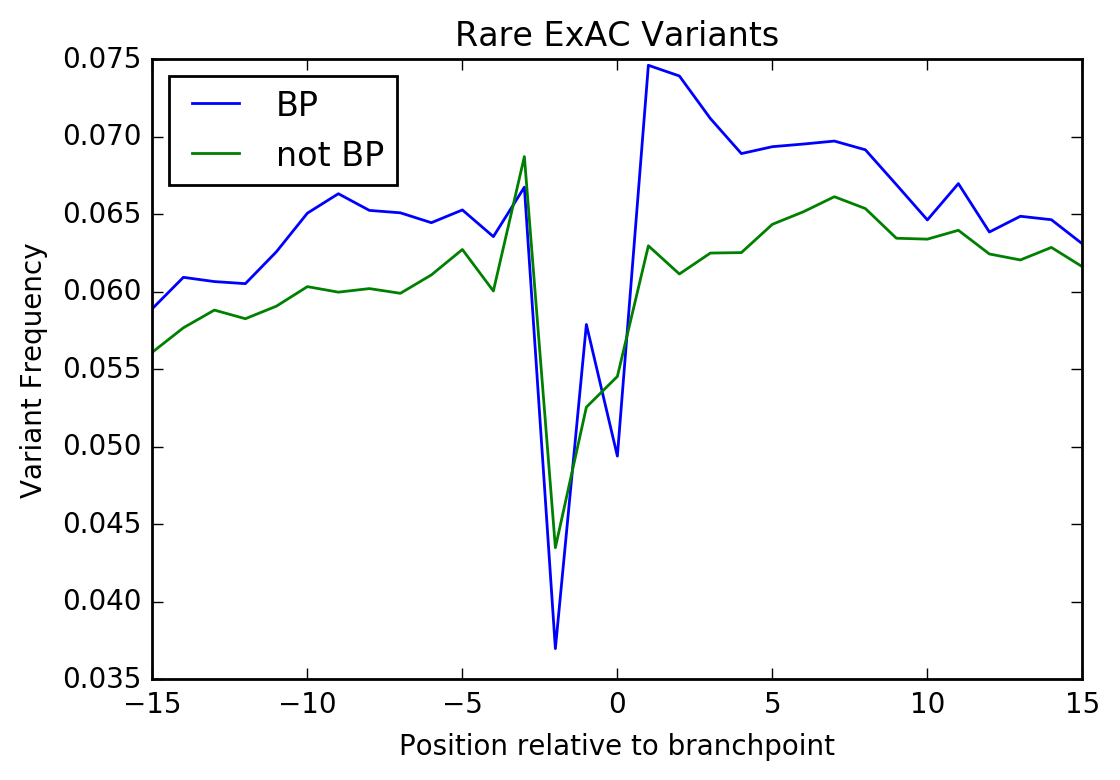

-15 (1.0532696918273872, 0.0017622160481776863)
-14 (1.0601487624580452, 0.00035394995408340001)
-13 (1.0333093115647616, 0.044693520763974835)
-12 (1.0413505387767013, 0.013229149546305762)
-11 (1.0633877541662826, 0.0001422717881482947)
-10 (1.084066689102928, 3.9816419911221333e-07)
-9 (1.1134361102881958, 1.268200153585305e-11)
-8 (1.0896651710197969, 6.8647904530724616e-08)
-7 (1.0927557531206233, 2.6494553580943069e-08)
-6 (1.0589492375442933, 0.00032109955025387348)
-5 (1.0435369203336988, 0.0069461089873373988)
-4 (1.0624189512517637, 0.00015944413527920381)
-3 (0.96922366544215288, 0.042224263946855245)
-2 (0.84442045526817011, 7.8561757160581661e-18)
-1 (1.1077614802536084, 1.3952055922386607e-09)
0 (0.90080325083603552, 1.8942897359531969e-09)
1 (1.1999474404699311, 6.6838066162061007e-33)
2 (1.2256577797646393, 6.8073727033380391e-40)
3 (1.1495648957330531, 1.8948866801581607e-19)
4 (1.1097448301458204, 2.2883122549782022e-11)
5 (1.0836362486075, 2.0111474899386743e-07)
6 (

In [82]:
from scipy.stats import norm

def compare_frequency(hits1, hits2, n1, n2, name1, name2, title):
    plt.plot(range(-K, K+1),  hits1 / n1, label = name1)
    plt.plot(range(-K, K+1),  hits2 / n2, label = name2)
    plt.title(title)
    plt.legend(loc = 'best')
    plt.ylabel('Variant Frequency')
    plt.xlabel('Position relative to branchpoint')
    plt.show()

    for i in range(2*K+1):
        print i-K, fisher_exact([[hits1[i], n1-hits1[i]],
                                 [hits2[i], n2-hits2[i]]])

compare_frequency(rare_bp_hits, rare_nbp_hits, count(bps), count(n_bps),
                  'BP', 'not BP', 'Rare ExAC Variants')

In [19]:
common_bp_hits = var_enrichment(benign[benign['ALFQMAX'] >=  .0001], bps)
common_nbp_hits = var_enrichment(benign[benign['ALFQMAX'] >=  .0001], n_bps)

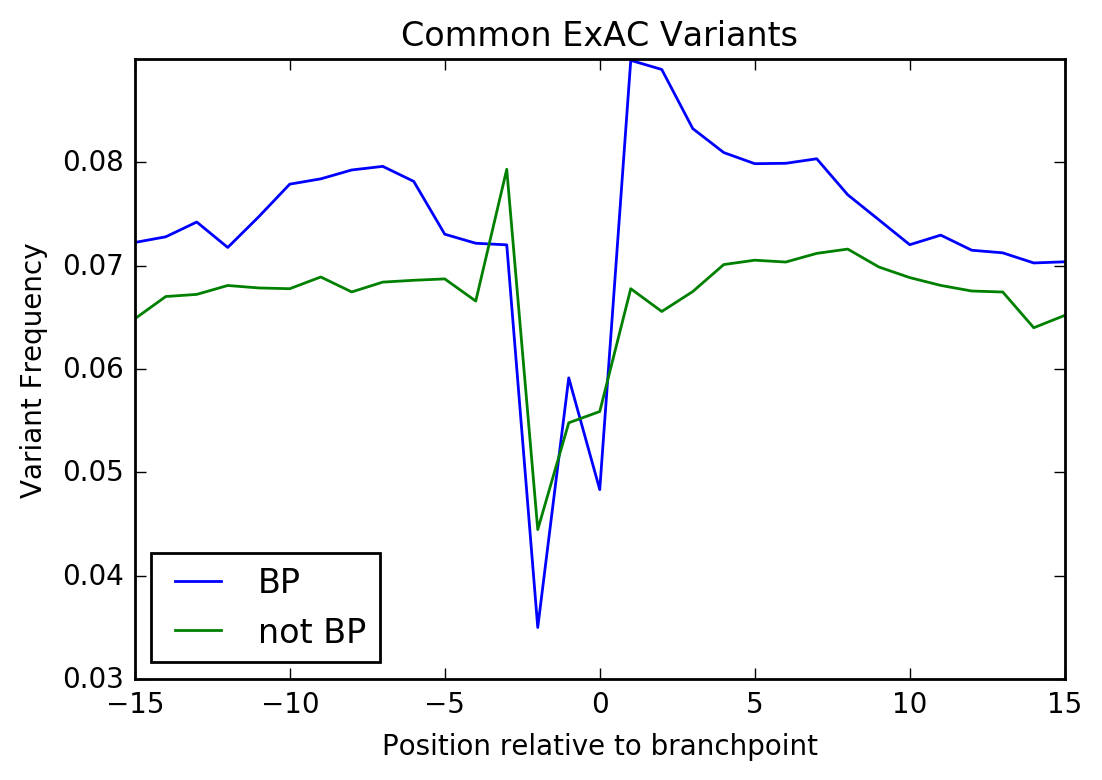

-15 (1.12280450903681, 3.3103225345529785e-14)
-14 (1.0930097089905213, 4.171763517803089e-09)
-13 (1.112535582237048, 1.3822767647626611e-12)
-12 (1.0582265488985181, 0.0001850341777145765)
-11 (1.1097908640341119, 3.7220664613437708e-12)
-10 (1.1619281853417054, 5.2052486582548236e-24)
-9 (1.1495359274189139, 3.9641038081501481e-21)
-8 (1.1900318939406704, 6.9738564176632767e-32)
-7 (1.1779208845320803, 1.1644416988550895e-28)
-6 (1.1513649175210268, 1.663405433644353e-21)
-5 (1.0678981418243538, 1.2530033630543602e-05)
-4 (1.0905558124299799, 1.1403019811771967e-08)
-3 (0.90063453198582533, 7.2636214206706749e-13)
-2 (0.77919280892091392, 2.1905040240287364e-36)
-1 (1.0843264996857453, 1.1648322142038914e-06)
0 (0.85785955758279897, 1.0868028237418597e-18)
1 (1.358309586041222, 7.7727551709669629e-101)
2 (1.3920992403619845, 4.2587386226474029e-115)
3 (1.2549027668300494, 2.7335126337375413e-54)
4 (1.1682197452506775, 1.8248300285721158e-26)
5 (1.143923853019974, 3.9209699973263422e

In [68]:
compare_frequency(common_bp_hits, common_nbp_hits, count(bps), count(n_bps),
                  'BP', 'not BP', 'Common ExAC Variants')

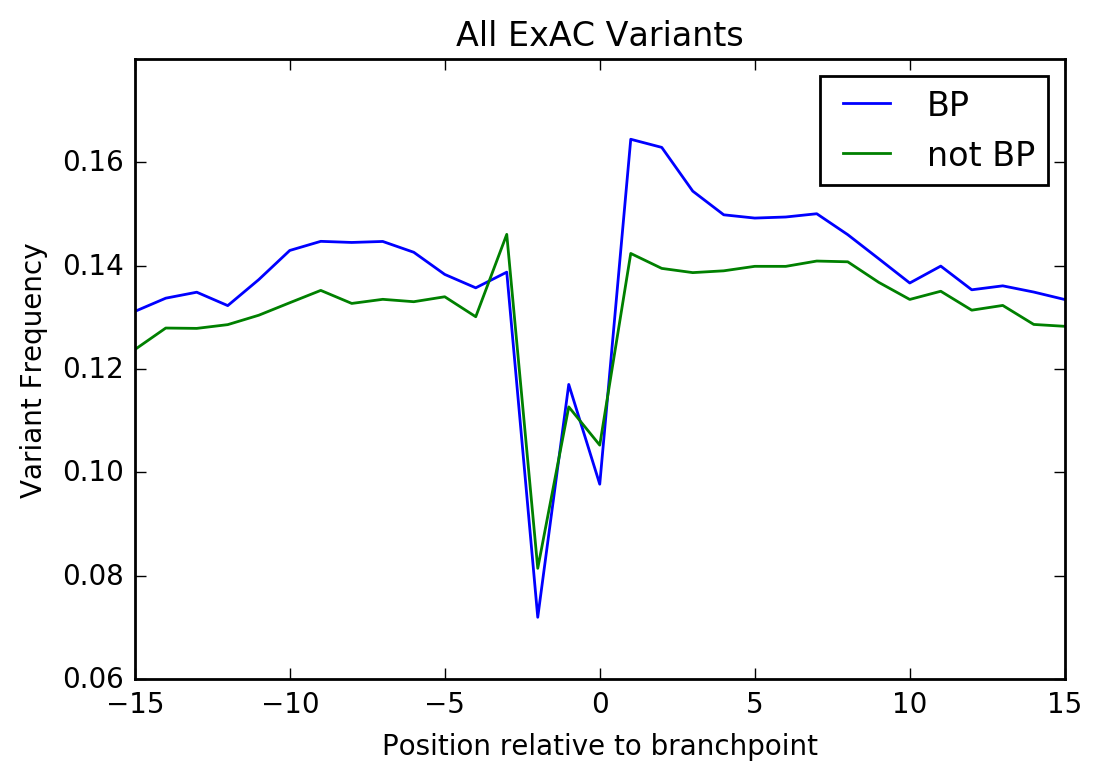

-15 (1.0687206710523149, 9.085917935879652e-09)
-14 (1.0521476218949766, 8.8384407012209546e-06)
-13 (1.0633105882571625, 7.58076884789377e-08)
-12 (1.0329778307182211, 0.0046420531074760013)
-11 (1.0612611486538528, 1.5260733104031159e-07)
-10 (1.0888903443166027, 2.6453734794529269e-14)
-9 (1.0821115999694266, 1.2426567550520389e-12)
-8 (1.1039761265765387, 7.7221406488052798e-19)
-7 (1.0981178396370241, 4.474061900427451e-17)
-6 (1.0839071245642489, 5.9018695328290253e-13)
-5 (1.0374625986516159, 0.0010809004296440145)
-4 (1.049740130439266, 1.9364208564945048e-05)
-3 (0.94185089118168452, 5.6729685845765364e-08)
-2 (0.87462433297546982, 2.5007078097700113e-20)
-1 (1.0436990667770383, 0.00040946275114717981)
0 (0.92040728393091731, 8.3865690697119641e-11)
1 (1.1857935579061301, 4.5484803616405903e-57)
2 (1.2006019432679425, 1.254508227452426e-64)
3 (1.1345249686505334, 5.5097268960021859e-31)
4 (1.0917171801137149, 1.2430167710096142e-15)
5 (1.0784875462869681, 5.5511420706585616e-1

In [69]:
compare_frequency(common_bp_hits+rare_bp_hits, common_nbp_hits+rare_bp_hits, count(bps), count(n_bps),
                  'BP', 'not BP', 'All ExAC Variants')

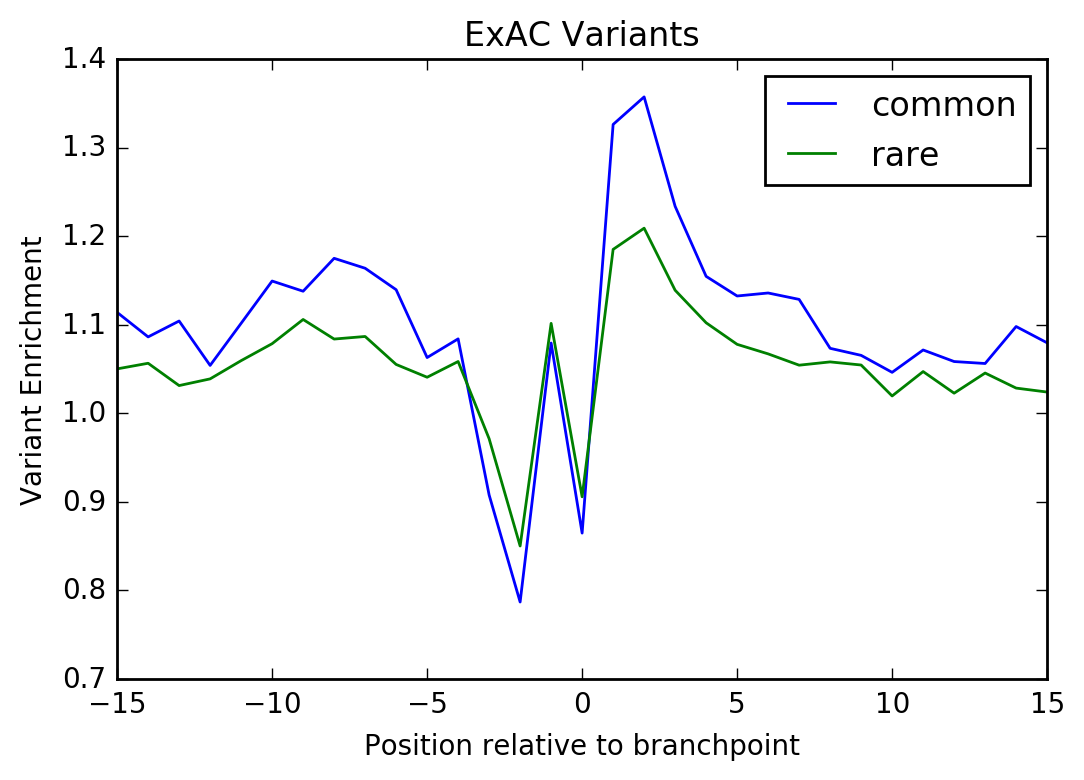

Fisher Exact test comparing enrichment in common to rare
-15 (1.0607546924157372, 0.99669899101158899)
-14 (1.0281637055690589, 0.90344696513379108)
-13 (1.0706817428360593, 0.9993110455329538)
-12 (1.0146312082742199, 0.75373412203408974)
-11 (1.0397985419694828, 0.96745623038288475)
-10 (1.0655647853378103, 0.99878546109423549)
-9 (1.0288429681821887, 0.91454434395136552)
-8 (1.0841043600799747, 0.99994284480851492)
-7 (1.0708896053156485, 0.99947625434329623)
-6 (1.0799736544774001, 0.99988326926340254)
-5 (1.0213731676729076, 0.84542085220010521)
-4 (1.0241557403101729, 0.87080023985432675)
-3 (0.93463529906651899, 0.00047400091255535217)
-2 (0.9256001398125191, 0.0024837379278439668)
-1 (0.9798591021244577, 0.19157702556856482)
0 (0.95476111040907186, 0.027254364147914312)
1 (1.1190481906166332, 0.99999998722555239)
2 (1.1226048893012275, 0.99999999271082274)
3 (1.0831978579643657, 0.99995205153618971)
4 (1.0475596370417088, 0.98831163891661533)
5 (1.0506496207166514, 0.9922423844

In [70]:
from scipy.stats import fisher_exact

def compare_enrichments(hits1, hits2, n_hits1, n_hits2, name1, name2, title):
    plt.plot(range(-K, K+1), hits1 / n_hits1, label = name1)
    plt.plot(range(-K, K+1), hits2 / n_hits2, label = name2)
    plt.legend(loc = 'best')
    plt.title(title)
    plt.ylabel('Variant Enrichment')
    plt.xlabel('Position relative to branchpoint')
    plt.show()
    
    print "Fisher Exact test comparing enrichment in {} to {}".format(name1, name2)
    for i in range(-K, K+1):
        i += K
        print i-K, fisher_exact([[hits1[i], n_hits1[i]],
                                 [hits2[i], n_hits2[i]]],
                                 'less')

compare_enrichments(common_bp_hits, rare_bp_hits, common_nbp_hits, rare_nbp_hits,
                    'common', 'rare', 'ExAC Variants')

In [24]:
v_common_bp_hits = var_enrichment(benign[benign['ALFQMAX'] >=  .001], bps)
v_common_nbp_hits = var_enrichment(benign[benign['ALFQMAX'] >=  .001], n_bps)

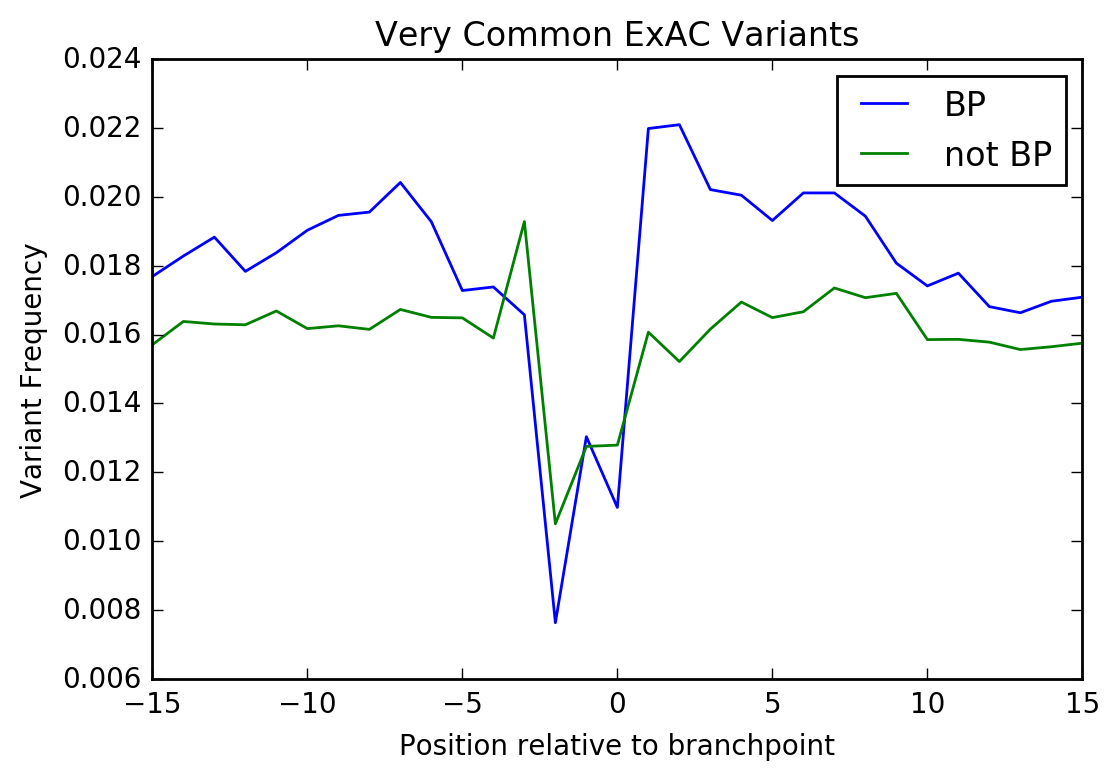

-15 (1.1283926376486388, 6.349099035580228e-05)
-14 (1.1181008667440089, 0.00016702060919805226)
-13 (1.1576544902584163, 6.6318802503264288e-07)
-12 (1.0969453721236342, 0.0019741653998735864)
-11 (1.1032761992577926, 0.00086250110297262977)
-10 (1.1800313014506971, 1.831207127285713e-08)
-9 (1.2010831549551499, 3.5613729267371662e-10)
-8 (1.2150459638122664, 2.6233303087500874e-11)
-7 (1.224992604287191, 1.4291792967150919e-12)
-6 (1.1714703375162303, 5.8686475070911457e-08)
-5 (1.0490014671903378, 0.11302289736032378)
-4 (1.0949780146629229, 0.0027300443725811327)
-3 (0.85719461105812089, 1.2511355639038718e-07)
-2 (0.72459250558209798, 3.9028029721219882e-15)
-1 (1.0223978223457804, 0.5276182057699772)
0 (0.85689746377249842, 1.5555511572781243e-05)
1 (1.3762294705699192, 2.4775291870776713e-29)
2 (1.4621856245919764, 6.8969889403283886e-40)
3 (1.2558592274007054, 3.7286917387136613e-15)
4 (1.1867558271680452, 2.4576469465361282e-09)
5 (1.1743061633221401, 3.6328795366453166e-08)
6

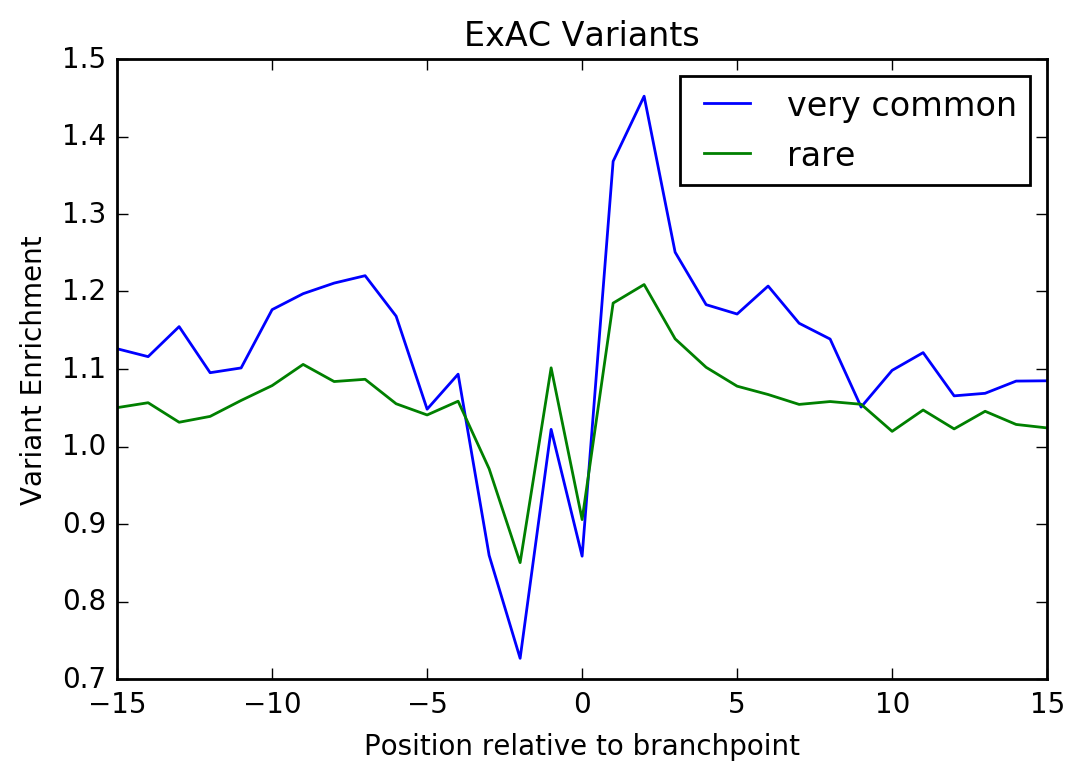

Fisher Exact test comparing enrichment in very common to rare
-15 (1.0723619273864493, 0.98112965968621535)
-14 (1.0562783399434128, 0.95163510979274601)
-13 (1.1196527839776045, 0.99969850658827775)
-12 (1.054259926870222, 0.94461672442463807)
-11 (1.0396029867840653, 0.88329424489039288)
-10 (1.0908658629596963, 0.99606415145581151)
-9 (1.0825162111238646, 0.99261350384048808)
-8 (1.1172011644749569, 0.99966103643956594)
-7 (1.1230120429546542, 0.99984616913831426)
-6 (1.1071077745218056, 0.99911770134346467)
-5 (1.0071675179340147, 0.59127810751374787)
-4 (1.0329483930493366, 0.83635698333998065)
-3 (0.88498030520568371, 8.6754184365402492e-05)
-2 (0.85476358960052801, 0.00027840966025238989)
-1 (0.92790075764066882, 0.024613199846719176)
0 (0.94784950584508298, 0.089377429738015074)
1 (1.1543645223661367, 0.99999700925961721)
2 (1.2009908740488355, 0.99999999389854266)
3 (1.0981338902712774, 0.99818492814918081)
4 (1.0733349085788715, 0.98670873755219568)
5 (1.0863799253656963, 0.9

In [71]:
compare_frequency(v_common_bp_hits, v_common_nbp_hits, count(bps), count(n_bps),
                  'BP', 'not BP', 'Very Common ExAC Variants')

compare_enrichments(v_common_bp_hits, rare_bp_hits, v_common_nbp_hits, rare_nbp_hits,
                    'very common', 'rare', 'ExAC Variants')

# No -2 T variant enrichments

The plot thickens.

In [34]:
def matched_noT(X, y, chroms, coords, strands):
    branch, not_branch = {}, {}
    bps, n_bps = {}, {}
    for chrom, pos, strand, target, seq in zip(chroms, coords, strands, y, X):
        bp = np.argmax(target)
        for i in range(K, L-K):
            if not seq[i, 0]*(1-seq[i-2, 3]): continue
            idx = pos + (i-L+1 if strand == '+' else L-i)
            if i == bp:
                if chrom not in bps: bps[chrom] = set()
                if idx in bps[chrom]: continue
                bps[chrom].add(idx)
                if i not in branch: branch[i] = set()
                branch[i].add((chrom, idx))
            else:
                if chrom not in n_bps: n_bps[chrom] = set()
                if idx in n_bps[chrom]: continue
                n_bps[chrom].add(idx)
                if i not in not_branch: not_branch[i] = set()
                if (chrom, idx) in not_branch[i]: continue
                not_branch[i].add((chrom, idx))
                
    for dist in branch.keys():
        num = min(len(branch[dist]), len(not_branch[dist]))
        branch[dist] = list(branch[dist])[:num]
        not_branch[dist] = list(not_branch[dist])[:num]
    
    n_bps = {}
    for key, value in not_branch.items():
        num = min(len(branch[key]), len(not_branch[key]))
        for (chrom, idx) in value:
            if chrom not in n_bps: n_bps[chrom] = set()
            assert idx not in n_bps[chrom]
            n_bps[chrom].add(idx)
    
    bps = {}
    for key, value in branch.items():
        num = min(len(branch[key]), len(not_branch[key]))
        for (chrom, idx) in value:
            if chrom not in bps: bps[chrom] = set()
            assert idx not in bps[chrom]
            bps[chrom].add(idx)

    return bps, n_bps

In [35]:
K = 15
bps_noT, n_bps_noT = matched_noT(X_all,  y_all, a_chroms, a_coords, a_strands)
print count(bps_noT), count(n_bps_noT)

37486.0 37486.0


In [36]:
rare_bp_hits_noT = var_enrichment(benign[benign['ALFQMAX'] <  .0001], bps_noT)
rare_nbp_hits_noT = var_enrichment(benign[benign['ALFQMAX'] <  .0001], n_bps_noT)

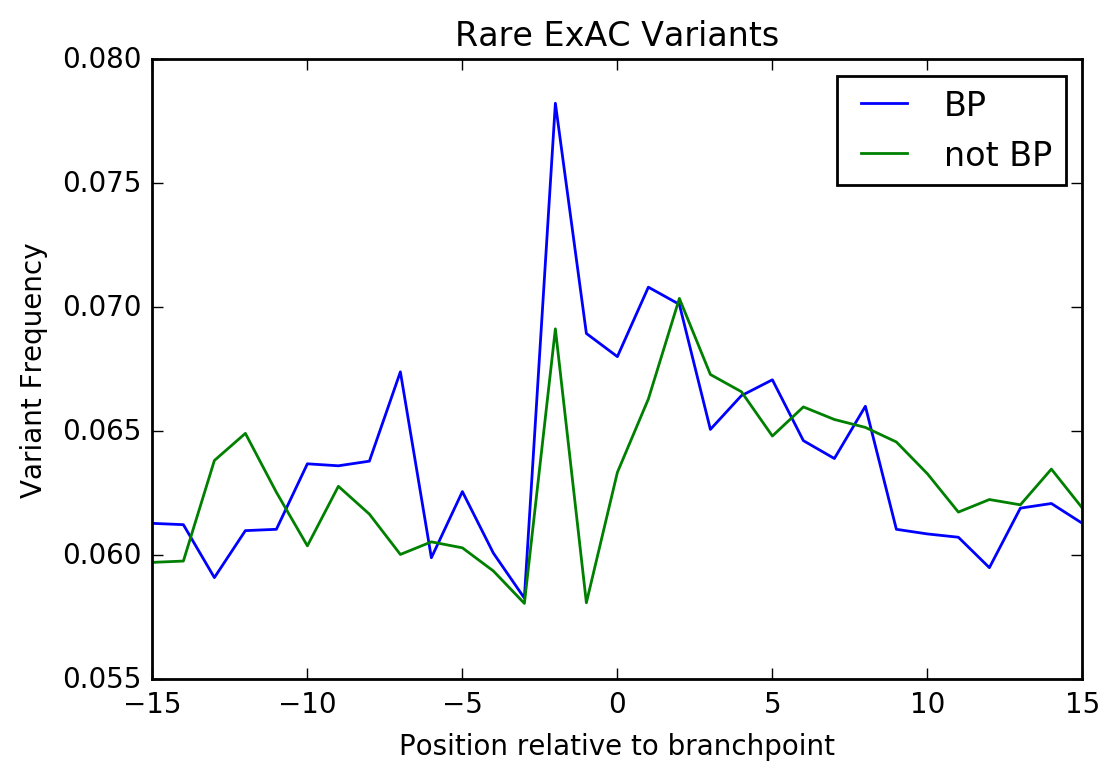

-15 (1.0280836857707814, 0.37423934698958083)
-14 (1.0261548458006715, 0.40807893199858192)
-13 (0.92135639395643609, 0.0074326904240558204)
-12 (0.93565694709113323, 0.028114249363486887)
-11 (0.97455622575514778, 0.40410930725936628)
-10 (1.0585209663312423, 0.062530708992811712)
-9 (1.01406944628105, 0.65246795901475174)
-8 (1.0369754863922853, 0.23403971296082104)
-7 (1.1315298245614036, 3.898930799330381e-05)
-6 (0.9887488316456593, 0.72399669178089399)
-5 (1.0401204200624892, 0.20135005409099507)
-4 (1.0129104357193288, 0.68862413086543584)
-3 (1.0039039197912467, 0.91301689938124175)
-2 (1.1427768308636534, 1.9867170151669514e-06)
-1 (1.2007958658020264, 1.174754858936721e-09)
0 (1.0790935056311133, 0.010294524862173143)
1 (1.0731898742015713, 0.015165867403179342)
2 (0.99632972154016575, 0.90896867268136849)
3 (0.96479930304082206, 0.22829813179112179)
4 (0.99742511781566245, 0.94157712010187866)
5 (1.037509393505512, 0.21637449739993805)
6 (0.97795278674295671, 0.4597953135207

In [73]:
compare_frequency(rare_bp_hits_noT, rare_nbp_hits_noT, count(bps_noT), count(n_bps_noT),
                  'BP', 'not BP', 'Rare ExAC Variants')

In [38]:
common_bp_hits_noT = var_enrichment(benign[benign['ALFQMAX'] >=  .0001], bps_noT)
common_nbp_hits_noT = var_enrichment(benign[benign['ALFQMAX'] >=  .0001], n_bps_noT)

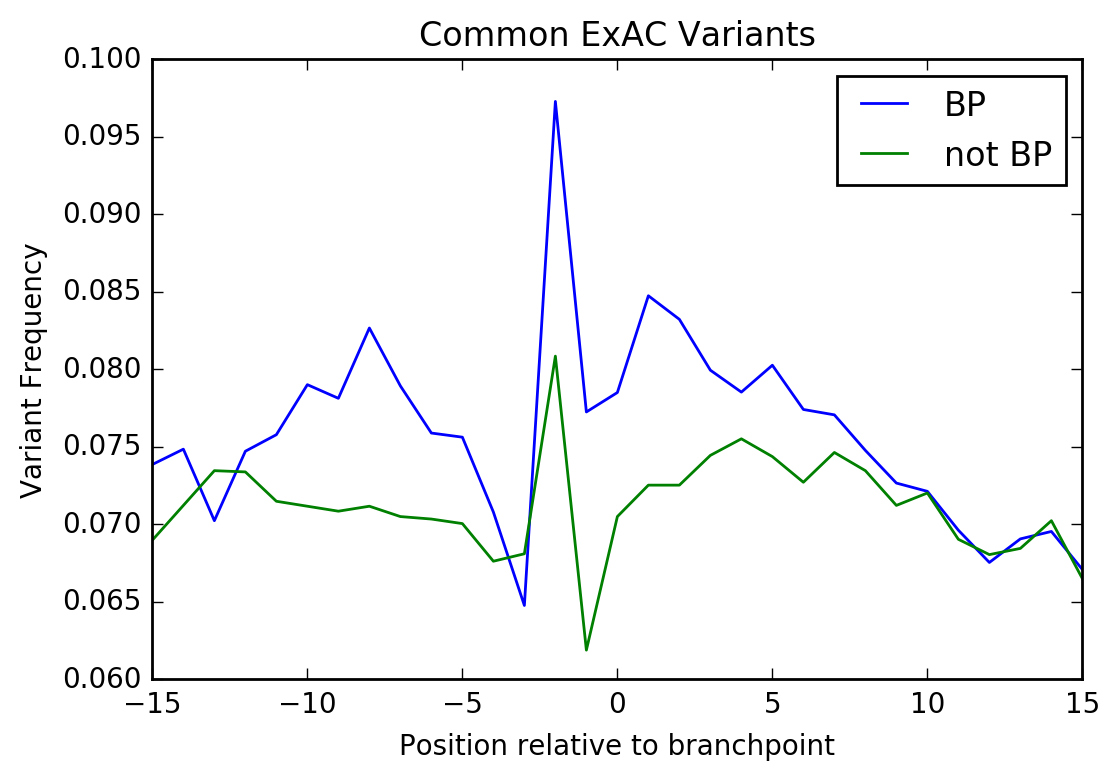

-15 (1.0764372307053582, 0.0098339231712601238)
-14 (1.0550766889559566, 0.058063337494422634)
-13 (0.95272890822389811, 0.089620632586649485)
-12 (1.0196495311181351, 0.49428192831037976)
-11 (1.0650233232978477, 0.025235738733767665)
-10 (1.1196905129798673, 4.8690926712336429e-05)
-9 (1.1115369134604789, 0.0001539916694992422)
-8 (1.1761637056621848, 3.703783612173513e-09)
-7 (1.1298529879139221, 1.2033501212008307e-05)
-6 (1.0853854895059714, 0.0036758047982291425)
-5 (1.0861306596746976, 0.0034564690551573286)
-4 (1.050538060609002, 0.089458993137361498)
-3 (0.94762802891784481, 0.068940319584149451)
-2 (1.2252043785938878, 2.9920223917851548e-15)
-1 (1.2691706593288274, 1.4200160109279027e-16)
0 (1.1232210534287925, 3.1820577159807011e-05)
1 (1.1841045018914889, 5.4971936357900504e-10)
2 (1.1609245851273424, 4.924101154763655e-08)
3 (1.0802488696011829, 0.0050206924216749582)
4 (1.0433312339032756, 0.12494384803076869)
5 (1.0862149023210341, 0.0026219690193590045)
6 (1.0700047456

In [74]:
compare_frequency(common_bp_hits_noT, common_nbp_hits_noT, count(bps_noT), count(n_bps_noT),
                  'BP', 'not BP', 'Common ExAC Variants')

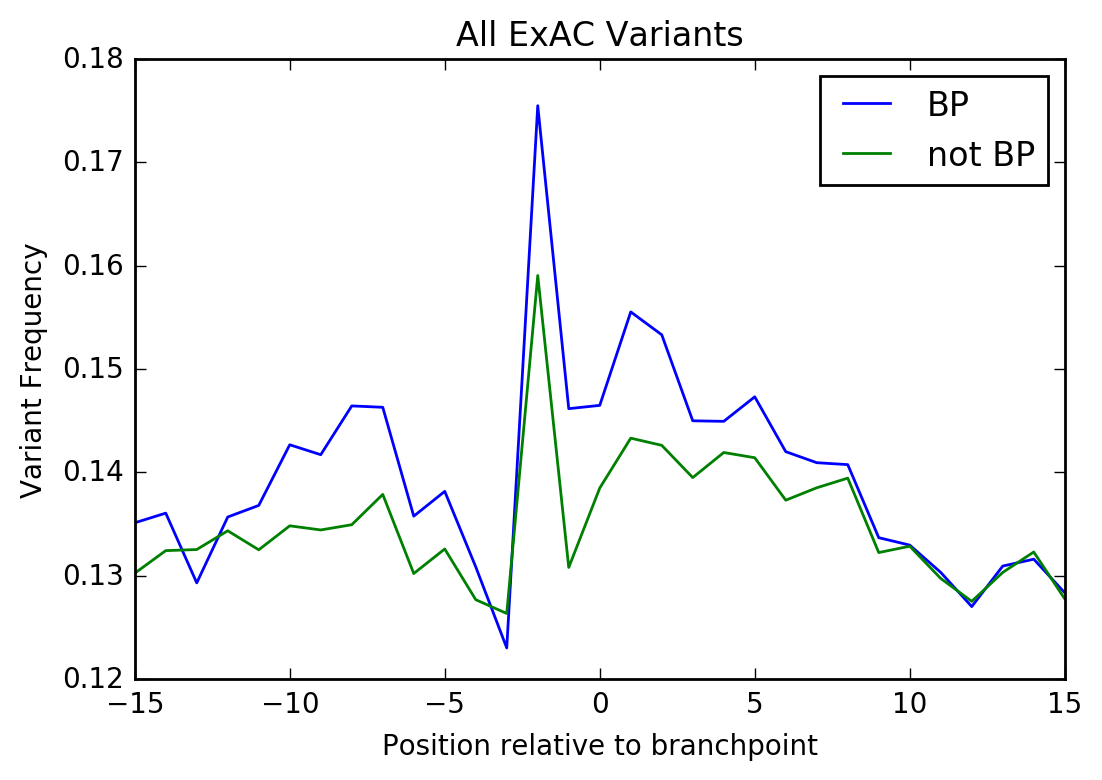

-15 (1.043340708775591, 0.050055722701019781)
-14 (1.0317116562289304, 0.14809918560938745)
-13 (0.97202719359228573, 0.19384347128055285)
-12 (1.0114870463526804, 0.60050990739908361)
-11 (1.0375507958807877, 0.086916697165079701)
-10 (1.067851952168186, 0.0019631713754385783)
-9 (1.063122229811301, 0.0039795129689195958)
-8 (1.0998293594967192, 6.2643024293259363e-06)
-7 (1.0716236678706033, 0.00098313161437192176)
-6 (1.0493081640541571, 0.025981706072261617)
-5 (1.0487935443782888, 0.026386081512125278)
-4 (1.0286074375205001, 0.19894472775361169)
-3 (0.96990449337169871, 0.17040879516095053)
-2 (1.1253103484833218, 1.7521198774813676e-09)
-1 (1.1375893190201274, 1.1930216425020999e-09)
0 (1.0677106857472582, 0.0017826377615402574)
1 (1.1009584182230008, 2.8367825941956755e-06)
2 (1.0885913418374358, 3.8759187681579831e-05)
3 (1.046076140639286, 0.032074408831179818)
4 (1.0248408943927223, 0.24320926242226731)
5 (1.0488925229526871, 0.022242674089126169)
6 (1.0398539204575421, 0.06

In [75]:
compare_frequency(common_bp_hits_noT+rare_bp_hits_noT, common_nbp_hits_noT+rare_bp_hits_noT,
                  count(bps_noT), count(n_bps_noT),
                  'BP', 'not BP', 'All ExAC Variants')

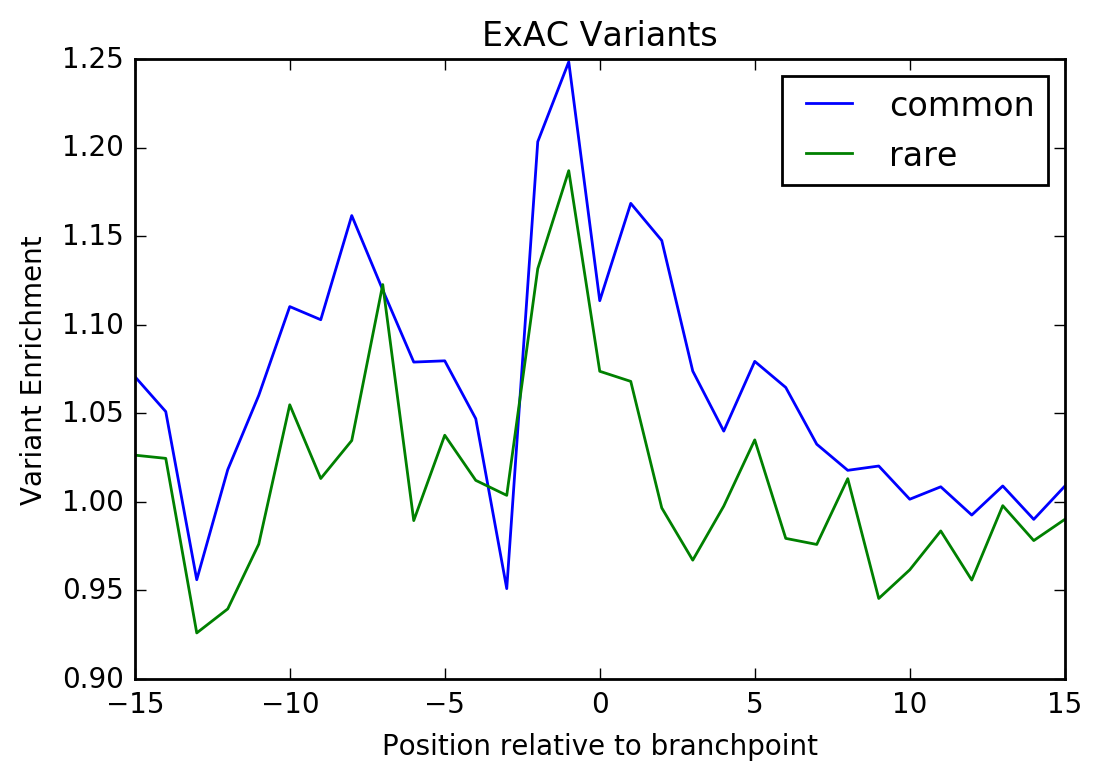

Fisher Exact test comparing enrichment in common to rare
-15 (1.0432889927068272, 0.8576391553571191)
-14 (1.0257691186878148, 0.74329073889477992)
-13 (1.0324454586377758, 0.79251633211374006)
-12 (1.0836554521593891, 0.97972498485768822)
-11 (1.0860434824600558, 0.98172402164940142)
-10 (1.0525616116167298, 0.90511638674589656)
-9 (1.0884844348386606, 0.98479802348186607)
-8 (1.1227388922683283, 0.99847112790605075)
-7 (0.99727407258231271, 0.48029200933576388)
-6 (1.090441412547188, 0.98512364317434387)
-5 (1.0404857345923444, 0.84408276468097698)
-4 (1.0344089477247971, 0.80219315066771679)
-3 (0.94753522339729235, 0.10058318994746955)
-2 (1.0633530542685918, 0.95560126244773114)
-1 (1.0517529507888128, 0.89843012803802402)
0 (1.0371002388016972, 0.82902198368220847)
1 (1.0940987349956444, 0.99113702391205316)
2 (1.1514648663904765, 0.9999027222181347)
3 (1.1103781001967725, 0.99677793574471729)
4 (1.0424351824258162, 0.8630373920339578)
5 (1.0428049995732545, 0.86462752181322311)


In [76]:
compare_enrichments(common_bp_hits_noT, rare_bp_hits_noT, common_nbp_hits_noT, rare_nbp_hits_noT,
                    'common', 'rare', 'ExAC Variants')

In [58]:
def alt_enrichment(v, bps, shift):
    alts = np.zeros((4,))
    refs = np.zeros((4,))
    for chrom, pos, strand, ref, alt in zip(v['CHROM'], v['POS'], v['strand'], v['REF'], v['ALT']):
        if strand == '+':
            s = -shift
        else:
            s = shift
            alt = genome.revcomp(alt)
            ref = genome.revcomp(ref)
        if ('chr'+str(chrom) in bps) and (pos+s in bps['chr'+str(chrom)]):
            alts[bases.index(alt)] += 1
            refs[bases.index(ref)] += 1
    return np.vstack([refs, alts]).astype(int)

print alt_enrichment(benign, bps_noT, 0)
print alt_enrichment(benign, n_bps_noT, 0)
print 
print alt_enrichment(benign, bps_noT, -2)
print alt_enrichment(benign, n_bps_noT, -2)

[[5483    0    0    8]
 [   0  900 3881  710]]
[[5003    0    0   13]
 [   2  760 3545  709]]

[[2107 2514 1957    0]
 [1751  449 2260 2118]]
[[2043 1901 1676    1]
 [1448  538 1945 1690]]


# pLI Variant Enrichment

In [26]:
pLI = {}
with open('../anno/fordist_cleaned_exac_r03_march16_z_pli_rec_null_data.txt') as fp:
    print fp.readline().strip()
    for line in fp:
        gene = line.split()[1]
        pli = float(line.split()[19])
        pLI[gene] = pli
len(pLI)

transcript	gene	chr	n_exons	cds_start	cds_end	bp	mu_syn	mu_mis	mu_lof	n_syn	n_mis	n_lof	exp_syn	exp_mis	exp_lof	syn_z	mis_z	lof_z	pLI	pRec	pNull


18225

In [27]:
pLI_idx     = np.array([gene in pLI and pLI[gene] >= 0.9 for gene in a_genes])
not_pLI_idx = np.array([gene in pLI and pLI[gene] < 0.9 for gene in a_genes])
print sum(pLI_idx), sum(not_pLI_idx)

56448 140792


In [28]:
pli_bps, pli_n_bps = matched(X_all[pLI_idx],  y_all[pLI_idx],
                             a_chroms[pLI_idx], a_coords[pLI_idx], a_strands[pLI_idx])
not_pli_bps, not_pli_n_bps = matched(X_all[not_pLI_idx],  y_all[not_pLI_idx],
                                     a_chroms[not_pLI_idx], a_coords[not_pLI_idx], a_strands[not_pLI_idx])

In [29]:
pli_bp_hits = var_enrichment(benign, pli_bps)
pli_nbp_hits = var_enrichment(benign, pli_n_bps)

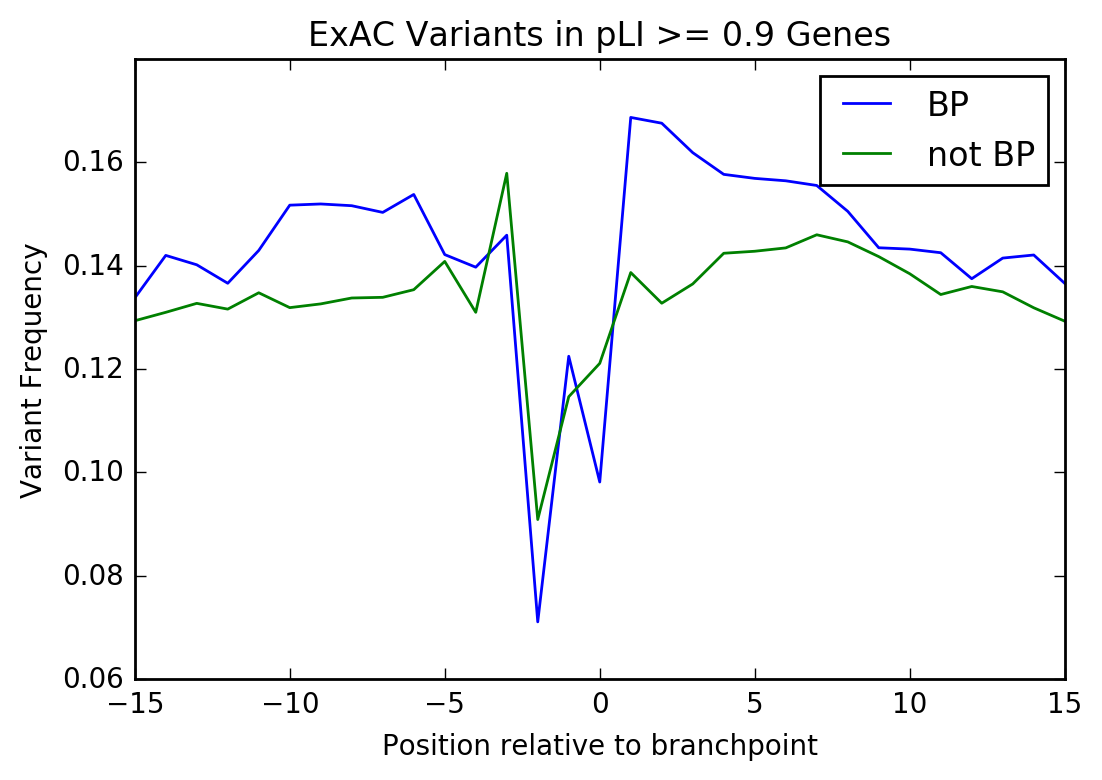

-15 (1.039335858055761, 0.071824679714535988)
-14 (1.0980463959783655, 8.7008249026493665e-06)
-13 (1.0654328510087765, 0.0026090224702923076)
-12 (1.0440373253435633, 0.042493280023728111)
-11 (1.0709320700618485, 0.0010384438570800146)
-10 (1.1772778734068525, 3.0745008966541896e-15)
-9 (1.1719758607987911, 1.5822008832563623e-14)
-8 (1.1574183819538966, 1.3969166327761829e-12)
-7 (1.1444913169731608, 6.6256226710509765e-11)
-6 (1.1609288186499589, 3.5687921028794884e-13)
-5 (1.0109444816985909, 0.60549599563888057)
-4 (1.0775388602797891, 0.00040545227104879695)
-3 (0.91117879413962655, 3.7494719633122446e-06)
-2 (0.76535200758726496, 6.6296621041543501e-24)
-1 (1.0778259100629524, 0.00080051371390129559)
0 (0.78968193110893525, 1.8343757102892252e-24)
1 (1.2604187835057421, 6.7130446798136597e-31)
2 (1.3153433509810029, 8.0852394056789334e-42)
3 (1.2221258826858659, 4.2124633555865674e-23)
4 (1.1272986879163231, 3.0446100718977815e-09)
5 (1.1171446337180302, 4.2969874322931417e-08)

In [79]:
compare_frequency(pli_bp_hits, pli_nbp_hits, count(pli_bps), count(pli_n_bps),
                  'BP', 'not BP', 'ExAC Variants in pLI >= 0.9 Genes')

In [31]:
not_pli_bp_hits = var_enrichment(benign, not_pli_bps)
not_pli_nbp_hits = var_enrichment(benign, not_pli_n_bps)

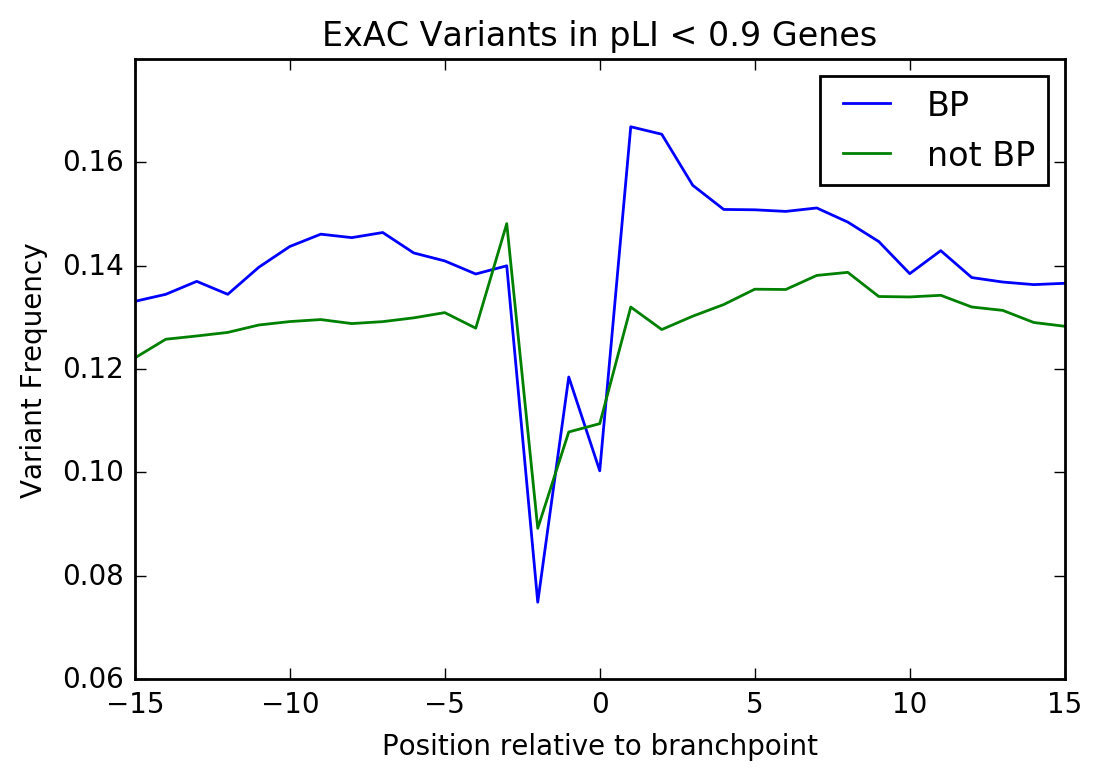

-15 (1.1035305257649497, 3.2942530282586447e-12)
-14 (1.0798862889402465, 4.304526439148058e-08)
-13 (1.0969232662892583, 3.4009155431206627e-11)
-12 (1.0670406979250489, 3.5833350288889213e-06)
-11 (1.1010490931653731, 3.6354576012265123e-12)
-10 (1.131319860098954, 2.8532147693092805e-19)
-9 (1.1493597145203911, 2.7734439526136231e-24)
-8 (1.151153126413516, 1.0847843191784127e-24)
-7 (1.156425651285989, 2.5847027727340743e-26)
-6 (1.1127547360949048, 8.1796273136564196e-15)
-5 (1.0889713666206644, 6.0513443222685463e-10)
-4 (1.0951305621485454, 6.0891896456058526e-11)
-3 (0.9359302961522018, 8.3965502522462466e-07)
-2 (0.82660037571237277, 1.9798509531290953e-28)
-1 (1.1119411387010332, 1.0749151594325573e-12)
0 (0.90727371477914975, 2.6922732020837834e-10)
1 (1.3173226814289853, 6.4458010018678037e-96)
2 (1.3548937249340889, 4.2602760729981136e-114)
3 (1.2303585374830561, 2.9957820637080868e-53)
4 (1.1635872526016269, 4.3846088596667206e-29)
5 (1.1336335740931212, 1.305535438663695

In [80]:
compare_frequency(not_pli_bp_hits, not_pli_nbp_hits, count(not_pli_bps), count(not_pli_n_bps),
                  'BP', 'not BP', 'ExAC Variants in pLI < 0.9 Genes')

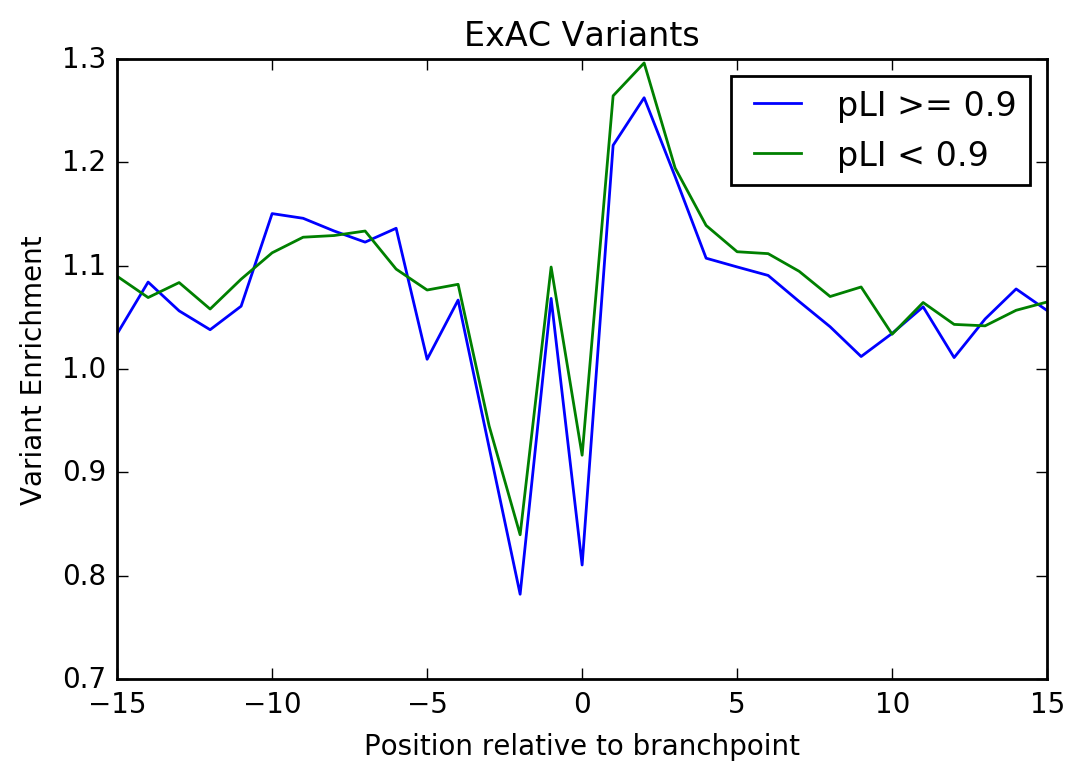

Fisher Exact test comparing enrichment in pLI >= 0.9 to pLI < 0.9
-15 (0.94890874409682613, 0.014364928589504927)
-14 (1.0140111192487204, 0.72715375308232899)
-13 (0.97472685557659433, 0.13995207079193556)
-12 (0.98109246596362365, 0.21267160246666608)
-11 (0.97594944445467513, 0.15002156092432653)
-10 (1.034100378301632, 0.92883905670488731)
-9 (1.0162356563018644, 0.7619011905882509)
-8 (1.0038804356699418, 0.57143684954682039)
-7 (0.99051678371737117, 0.34337149186048915)
-6 (1.0360077108188508, 0.9403332407989119)
-5 (0.93771575835227039, 0.0027050911570843088)
-4 (0.98589647205218522, 0.27637624023881147)
-3 (0.97802886877729023, 0.16201594566665042)
-2 (0.9314469908734444, 0.010077314899709056)
-1 (0.9723426574405134, 0.13549789038932533)
0 (0.88407407857817266, 1.4370706876285768e-06)
1 (0.96213299515723072, 0.041798088334904622)
2 (0.97401574142444791, 0.1227653007223934)
3 (0.99300577674688495, 0.38184671851588908)
4 (0.97218573676026621, 0.10649872787279367)
5 (0.98678521427

In [90]:
compare_enrichments(pli_bp_hits, not_pli_bp_hits, pli_nbp_hits, not_pli_nbp_hits,
                    'pLI >= 0.9', 'pLI < 0.9', 'ExAC Variants')